In [1]:
import ray
GPU_UTILIZATION = 0.0
ray.init(num_gpus=GPU_UTILIZATION)

2023-11-24 23:14:41,031	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-24 23:14:42,900	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [2]:
from ray.rllib.algorithms.ppo import PPOConfig

config = PPOConfig().training(gamma=0.9, lr=0.0001, train_batch_size=512, sgd_minibatch_size=256)
config = config.resources(num_gpus=GPU_UTILIZATION, num_learner_workers=1, num_gpus_per_worker=0, num_gpus_per_learner_worker=GPU_UTILIZATION)
config = config.rollouts(num_rollout_workers=4,create_env_on_local_worker=True)

algo = config.build(env="CartPole-v1")  

2023-11-24 23:14:45,709	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-24 23:14:46,297	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
/home/przemek/miniconda3/envs/ray_projects/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::Deprec

In [3]:
from time import time 
init_eval = algo.evaluate()

t1 = time()
for i in range(32):
    print(i,end='\r')
    algo.train()

print(time() - t1)
post_eval = algo.evaluate()

(_WrappedExecutable pid=7866) Setting up process group for: env:// [rank=0, world_size=1]


20.473066568374634


In [4]:
print('Mean reward per episode')
print('Before training: ',init_eval['evaluation']['episode_reward_mean'])
print('After training: ',post_eval['evaluation']['episode_reward_mean'])

Mean reward per episode
Before training:  24.173076923076923
After training:  245.25


In [10]:
import gymnasium as gym 
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [11]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
model = algo.get_policy().model

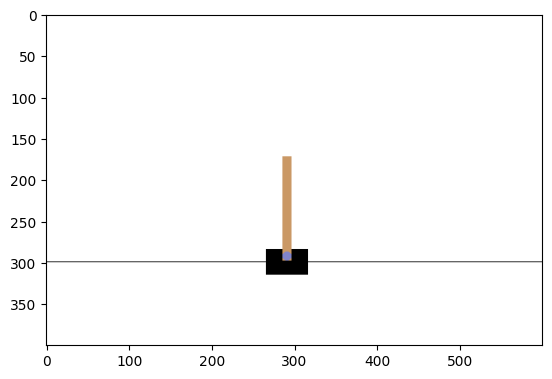

In [14]:
next_state = env.reset()[0]
num_steps = 120

for step in range(num_steps):
    with torch.no_grad():
        action = model({'obs': torch.Tensor(next_state.reshape([1,4]))})['action_dist_inputs'].argmax().item()

    next_state, reward, done = env.step(action)[:3]

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    print(step, end='\r')
    
    if done:
        print(f"Episode finished after {step+1} steps")
        break